## LSTM Model

**Long Short-Term Memory (LSTM) models are highly advantageous for crypto price prediction due to their ability to capture long-term dependencies, handle sequential and irregularly sampled time series data, automatically extract relevant features, model complex market dynamics, and adapt to specific prediction tasks. By effectively capturing patterns over extended periods, handling irregular data intervals, and automatically learning from raw data, LSTMs excel in predicting cryptocurrency prices, making them a preferred choice for analyzing the volatile and complex nature of crypto markets.**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Download ETH data
eth_data = yf.download('ETH-USD', start='2017-11-09', end='2024-03-15')

# Drop rows with missing values
eth_data.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


Epoch 1/100


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0254 - val_loss: 0.0020
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 4.2413e-04
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 4.9450e-04
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 4.9351e-04
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 3.8347e-04
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 3.6595e-04
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 4.1072e-04
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 4.4192e-04
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

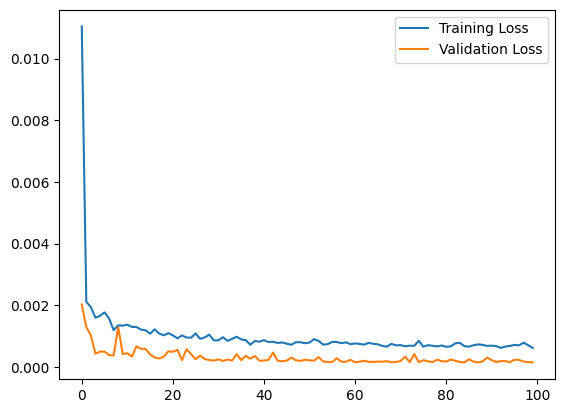

In [4]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Feature selection
eth_data = eth_data[['Close']]

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(eth_data)

# Define function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Choose sequence length (input window)
seq_length = 10

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [8]:
# Define function to forecast future values
def forecast_future_values(model, X, num_days):
    forecast = []
    current_sequence = X[-seq_length:]  # Get the last sequence from the data
    for _ in range(num_days):
        # Predict the next value
        next_value = model.predict(current_sequence.reshape(1, seq_length, 1))[0][0]
        # Add the predicted value to the forecast list
        forecast.append(next_value)
        # Update current sequence by removing the first value and appending the predicted value
        current_sequence = np.append(current_sequence[1:], next_value)
    return forecast

# Forecast future values
future_forecast = forecast_future_values(model, X_val[-1], 6)

# Inverse scaling to get actual prices
actual_prices = scaler.inverse_transform(y_val[-6:].reshape(-1, 1))
predicted_prices = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [12]:
from sklearn.metrics import mean_squared_error

# Inverse scaling
actual_prices = scaler.inverse_transform(y_val[-6:].reshape(-1, 1))
predicted_prices = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print("Root Mean Square Error (RMSE):", rmse)


Root Mean Square Error (RMSE): 75.97808043100311


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


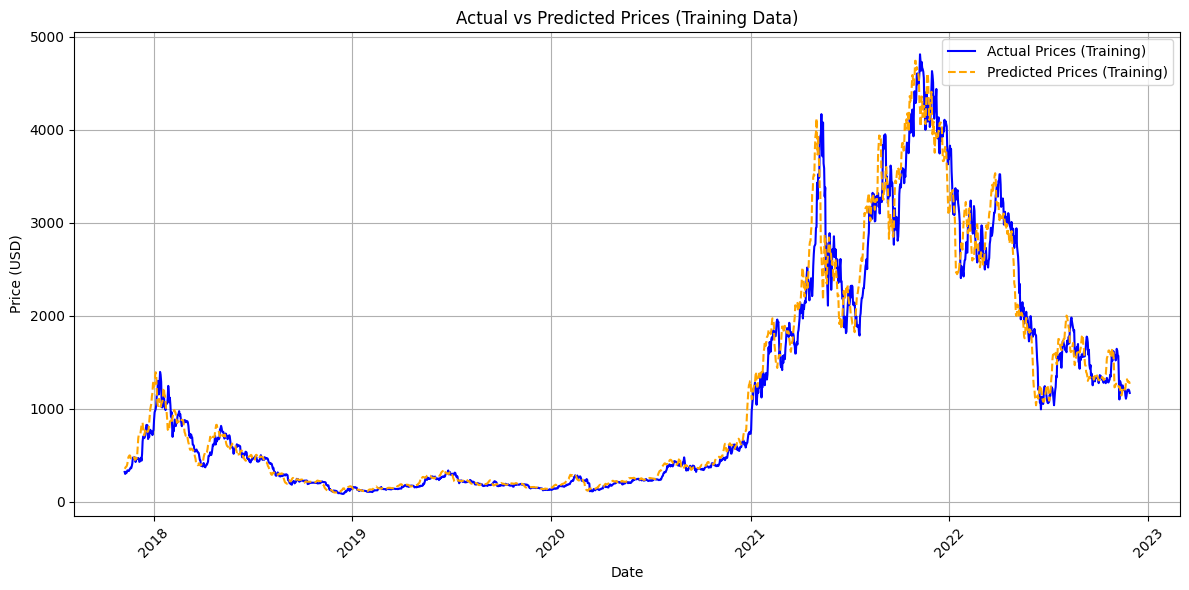

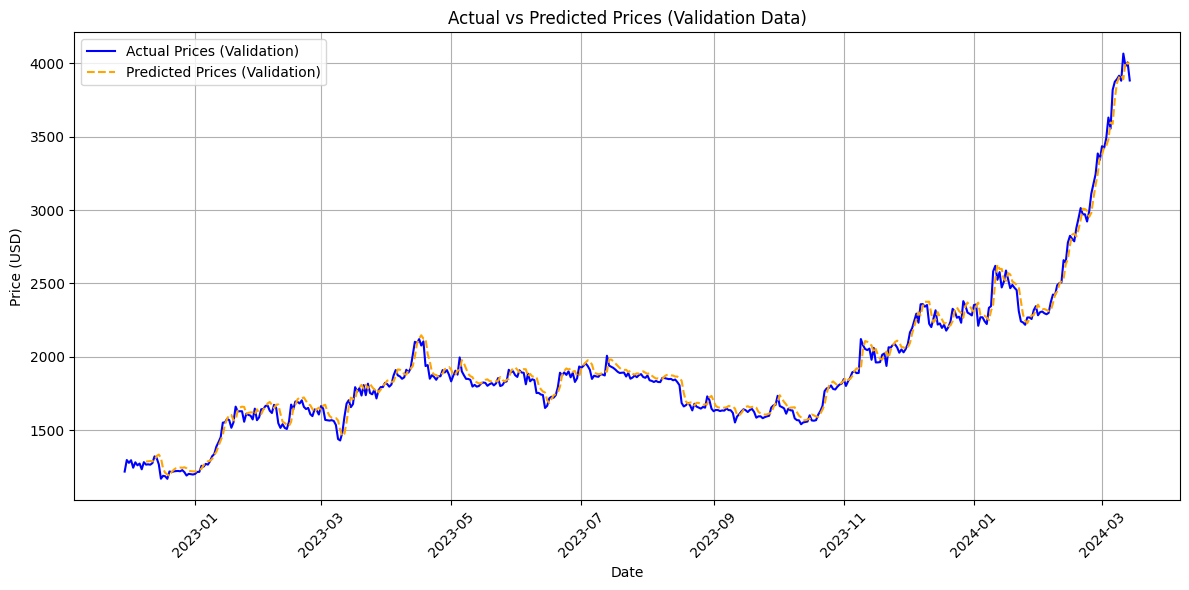

In [10]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Inverse transform the scaled predicted prices
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_val_pred_inv = scaler.inverse_transform(y_val_pred)

# Plot actual and predicted prices for training data
plt.figure(figsize=(12, 6))
plt.plot(eth_data.index[:train_size], eth_data['Close'][:train_size], label='Actual Prices (Training)', color='blue')
plt.plot(eth_data.index[:train_size][-len(y_train_pred_inv):], y_train_pred_inv, label='Predicted Prices (Training)', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted Prices (Training Data)')

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot actual and predicted prices for validation data
plt.figure(figsize=(12, 6))
plt.plot(eth_data.index[train_size:], eth_data['Close'][train_size:], label='Actual Prices (Validation)', color='blue')
plt.plot(eth_data.index[train_size:][-len(y_val_pred_inv):], y_val_pred_inv, label='Predicted Prices (Validation)', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted Prices (Validation Data)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


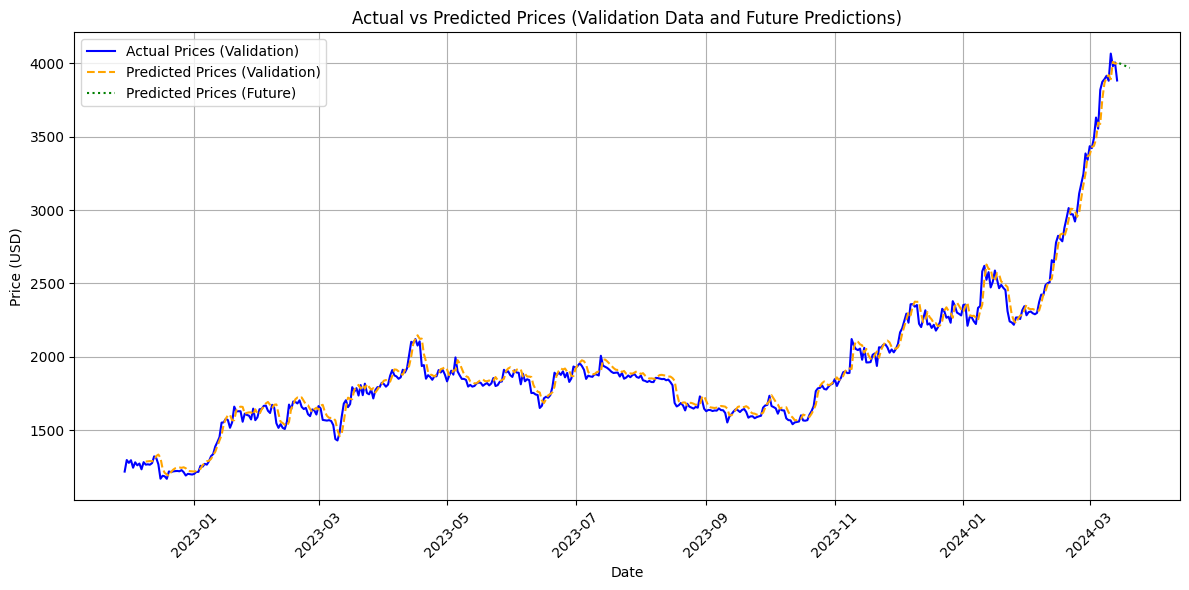

Date		Predicted Price
2024-03-15	$4000.66
2024-03-16	$3995.34
2024-03-17	$3988.85
2024-03-18	$3981.89
2024-03-19	$3975.16
2024-03-20	$3968.80


In [11]:
# Predict the next 6 days' prices
future_forecast = forecast_future_values(model, X_val[-1], 6)

# Inverse transform the scaled predicted prices
future_forecast_inv = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# Extend dates to include the next 6 days
next_days = pd.date_range(start=eth_data.index[-1] + pd.Timedelta(days=1), periods=6)

# Plot actual and predicted prices for validation data
plt.figure(figsize=(12, 6))
plt.plot(eth_data.index[train_size:], eth_data['Close'][train_size:], label='Actual Prices (Validation)', color='blue')
plt.plot(eth_data.index[train_size:][-len(y_val_pred_inv):], y_val_pred_inv, label='Predicted Prices (Validation)', linestyle='dashed', color='orange')
plt.plot(next_days, future_forecast_inv, label='Predicted Prices (Future)', linestyle='dotted', color='green')
plt.title('Actual vs Predicted Prices (Validation Data and Future Predictions)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the date and predicted value for each of the next 6 days
print("Date\t\tPredicted Price")
for date, price in zip(next_days, future_forecast_inv):
    print(f"{date.strftime('%Y-%m-%d')}\t${price[0]:.2f}")